In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]", appName="Assignment 1-Part B")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark Part B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.partb_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.partb_coll")\
        .getOrCreate()

# Step 02: Create Dataframe

### We will read Crime_Statistics_SA_2010_present.csv file. To create a DataFrame, we will use a SparkSession object created earlier called spark
### header=True means that very first row in the csv file are actually the column names
### No of records in the dataframe df using count()
### inferSchema - infers the input schema automatically from data. If none is set, it uses the default value False

In [3]:
df = spark.read.csv('Crime_Statistics_SA_2010_present.csv',inferSchema=True, header=True)
#No of records in the dataframe df
print(df.count())

727408


# Step 03: Write to Database
### We can write df dataframe to MongoDB database and collection specified in the spark.mongodb.output.uri option by using the write method. 

In [4]:
# Write to MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

# Step 04: Read from Database
### From the spark session object we can use read() method to read data from MongoDB. The result will be a dataframe

In [5]:
# Fetching data from mongodb collection
df_read = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

### Displaying the schema of the data frame df
### printSchema() method prints out the dataframe df schema

In [7]:
df_read.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



# Step 05: Calculate the statistics of numeric and string columns
### If we want to have a look at the statistical summary of any particular column of a dataframe, we can use describe() method. If not specified, it shows the statistical summary of the dataframe. 
#### For 'Offence Count' column 

In [8]:
# For computing summary statistics
df.describe('Offence Count').show();

+-------+------------------+
|summary|     Offence Count|
+-------+------------------+
|  count|            727407|
|   mean|1.1715174585892079|
| stddev|0.5787050930378146|
|    min|                 1|
|    max|                28|
+-------+------------------+



#### For 'Reported Date' column

In [9]:
df.describe('Reported Date').show();

+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       727407|
|   mean|         null|
| stddev|         null|
|    min|    1/01/2011|
|    max|    9/12/2018|
+-------+-------------+



### Explanation: From the above statistics for the 'Reported Date' column, minimum and maximum reported date is not correct. Because 'Reported Date' column is string type. When the data type will be converted to date format then we would get the correct minimum and maximum date.

# Step 06: Change the data type of a column
### You can drop the rows containing any null or NaN values using dataframe.na.drop()
### In step 8, when I tried to do date related operation, I did get some error for null or NaN values. Additionally, in the assessment discussion, paras told us to get rid of null values.

### https://lms.monash.edu/mod/forum/discuss.php?d=1717360

In [10]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
df = df.na.drop()

### udf is a feature of spark sql to define new column based function
### strptime() method creates a datetime object from a given string. But the string needs to be in a certain format.
### strptime() takes two arguments. One is string (that be converted to datetime) and another one is format code.

In [11]:
dateFunc =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

In [12]:
df = df.withColumn('Reported Date', dateFunc(col('Reported Date')))

# Step 07: Preliminary data analysis
### No of level 2 offences
#### Here I'm selecting the distinct values of the 'Offence Level 2 Description' column which would provide the number of level 2 offences.

In [16]:
level2 = df.select('Offence Level 2 Description').distinct().collect()
print("Total number of level 2 offence: ",len(level2))

Total number of level 2 offence:  9


### * symbol is used to print the list elements in a single line with space. To print all elements in new lines we have use sep = "\n". Previously full column content is not visible properly. That's why I used this 

In [18]:
#Displaying the list of level 2 offences
print(*level2,sep = "\n")

Row(Offence Level 2 Description='ROBBERY AND RELATED OFFENCES')
Row(Offence Level 2 Description='PROPERTY DAMAGE AND ENVIRONMENTAL')
Row(Offence Level 2 Description='SEXUAL ASSAULT AND RELATED OFFENCES')
Row(Offence Level 2 Description='HOMICIDE AND RELATED OFFENCES')
Row(Offence Level 2 Description='ACTS INTENDED TO CAUSE INJURY')
Row(Offence Level 2 Description='SERIOUS CRIMINAL TRESPASS')
Row(Offence Level 2 Description='OTHER OFFENCES AGAINST THE PERSON')
Row(Offence Level 2 Description='FRAUD DECEPTION AND RELATED OFFENCES')
Row(Offence Level 2 Description='THEFT AND RELATED OFFENCES')


### Number of offences against the person in 'Offence Level 2 Description' column
#### Here dataframe is filtered with the checking that is 'Offence Level 2 Description' column contain value 'OFFENCES AGAINST THE PERSON' At the end count returns the no of rows that the condition fulfil

In [17]:
df.filter(df['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON' ).count()

155909

### Number of offences against the person in 'Offence Level 2 Description' column

In [20]:
df.filter(df['Offence Level 2 Description'] == 'OFFENCES AGAINST THE PERSON' ).count()

0

## serious criminal tresspasses with more than 1 offence count
### At first  it is checked that 'Offence Level 2 Description' column contains value 'SERIOUS CRIMINAL TRESPASS' and if first condition is true then it checks another column 'Offence Count' contains value greater than one.

In [18]:
df.filter((df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS') & (df['Offence Count'] > 1)).count()

8574

### Same concept for 'Offence Level 1 Description' column

In [22]:
df.filter((df['Offence Level 1 Description'] == 'SERIOUS CRIMINAL TRESPASS') & (df['Offence Count'] > 1)).count()

0

## percentage of crimes are offences against the property

In [19]:
against_property = df.filter(df['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY' ).count()
total = df.select('Offence Level 1 Description').count()
percentage = ((against_property*100) / total)
print("percentage of crimes are offences against the property: ",percentage)

percentage of crimes are offences against the property:  78.55213977860042


### Here against_property contains the number of crimes which are offences againt the property. total contains the number of rows in the 'Offence Level 1 Description' column. percentage contains the percentage of crimes are offences against the property. I am considering per row denotes one crime.

# Step 08: Exploratory data analysis

## Find the number of crimes per year
### I am selecting two columns 'Reported Date' and 'Offence Count'. year('Reported Date') fetching only the year from the actual date and then groupping the data by year. We can consider number of crimes two ways. Whether it is offence count or per row denotes one crime. In the following section I will use both sum if I consider 'Offence Count' and count if I consider per row denotes one crime. 

In [27]:
from pyspark.sql.functions import year
# Find the number of crimes per year
crimes_peryear = df.select('Reported Date','Offence Count').groupBy(year('Reported Date').alias('Year')).sum().withColumnRenamed('sum(Offence Count)','sum').orderBy('Year').collect()
crimes_peryear

[Row(Year=2010, sum=61382),
 Row(Year=2011, sum=122176),
 Row(Year=2012, sum=112953),
 Row(Year=2013, sum=106761),
 Row(Year=2014, sum=101727),
 Row(Year=2015, sum=105628),
 Row(Year=2016, sum=107566),
 Row(Year=2017, sum=50144),
 Row(Year=2018, sum=55570),
 Row(Year=2019, sum=27753)]

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

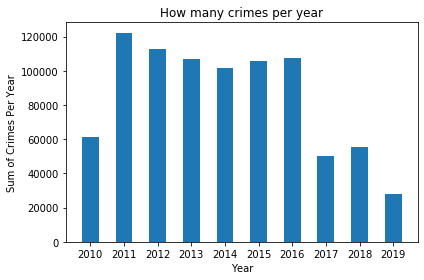

In [26]:
# prepare data
y_axis = [row['sum'] for row in crimes_peryear]

# plot
bar_width = 0.5
objects= ([row['Year'] for row in crimes_peryear])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')
plt.xticks(y_pos, objects)
plt.xlabel('Year')
plt.ylabel('Sum of Crimes Per Year')
plt.title('How many crimes per year')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes per year. Overall, in 2011 crimes did occur than any other year from 2010 to 2019. After 2010 crimes suddenly jumped to 122176 which is approximately double of 2010. After 2011, crimes decreased slowly until it is 2015. From 2015 to 2016 crimes increased a little bit. After 2016, crimes suddenly dropped in the next year 2017. In the current year 2019, crimes are much less compared to any other year. 
### In the following section if I consider per row as one crime - count() method is used

In [28]:
from pyspark.sql.functions import year
# Find the number of crimes per year
crimes_peryear = df.select('Reported Date','Offence Count').groupBy(year('Reported Date').alias('Year')).count().orderBy('Year').collect()
crimes_peryear

[Row(Year=2010, count=51800),
 Row(Year=2011, count=102838),
 Row(Year=2012, count=96041),
 Row(Year=2013, count=91354),
 Row(Year=2014, count=87658),
 Row(Year=2015, count=90936),
 Row(Year=2016, count=92036),
 Row(Year=2017, count=42961),
 Row(Year=2018, count=47522),
 Row(Year=2019, count=23775)]

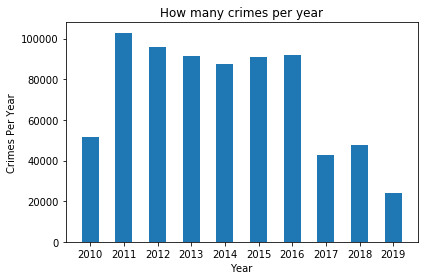

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
y_axis = [row['count'] for row in crimes_peryear]

# plot
bar_width = 0.5
objects= ([row['Year'] for row in crimes_peryear])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')
plt.xticks(y_pos, objects)
plt.xlabel('Year')
plt.ylabel('Crimes Per Year')
plt.title('How many crimes per year')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes per year. Overall, in 2011 crimes did occur than any other year from 2010 to 2019. After 2010 crimes suddenly jumped to 102838 which is approximately double of 2010. After 2011, crimes decreased slowly until it is 2015. From 2015 to 2016 crimes increased a little bit. After 2016, crimes suddenly dropped in the next year 2017. In the current year 2019, crimes are much less compared to any other year. 

## Find the number of crimes per month.
### I am selecting two columns 'Reported Date' and 'Offence Count'. month('Reported Date') fetching only the month from the actual date and then groupping the data by month. We can consider number of crimes two ways. Whether it is offence count or per row denotes one crime. In the following section I will use both sum() if I consider 'Offence Count' and count() if I consider per row denotes one crime. 

In [31]:
from pyspark.sql.functions import month
crimes_permonth = df.select('Reported Date','Offence Count').groupBy(month('Reported Date').alias('Month')).sum().withColumnRenamed('sum(Offence Count)','sum').orderBy('Month').collect()
crimes_permonth

[Row(Month=1, sum=77434),
 Row(Month=2, sum=70373),
 Row(Month=3, sum=74876),
 Row(Month=4, sum=60027),
 Row(Month=5, sum=64231),
 Row(Month=6, sum=60678),
 Row(Month=7, sum=70907),
 Row(Month=8, sum=72799),
 Row(Month=9, sum=72552),
 Row(Month=10, sum=77119),
 Row(Month=11, sum=75129),
 Row(Month=12, sum=75535)]

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

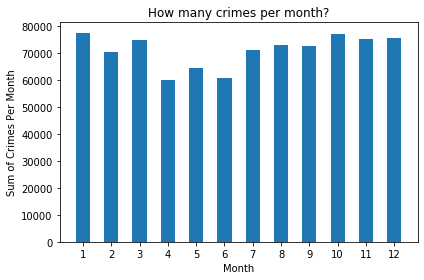

In [33]:
# prepare data
y_axis = [row['sum'] for row in crimes_permonth]

# plot
bar_width = 0.5
objects= ([row['Month'] for row in crimes_permonth])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')
plt.xticks(y_pos, objects)
plt.xlabel('Month')
plt.ylabel('Sum of Crimes Per Month')
plt.title('How many crimes per month?')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes per month. Overall, in January [Denotes 1] crimes did occur than any other months. From January to March(1 to 3) crimes did fluctuate a little bit. But in April(4) crimes dropped and it was arount 60000. From April to June (4-6) again crimes did fluctuate but in July(7) crimes started to increase again and remained steady from July to September (7-9). Again in October it did rise a little bit and did fluctuate a little bit till December(12). 
### In the following section if I consider per row as one crime - count() method is used

In [34]:
from pyspark.sql.functions import month
crimes_permonth = df.select('Reported Date','Offence Count').groupBy(month('Reported Date').alias('Month')).count().orderBy('Month').collect()
crimes_permonth

[Row(Month=1, count=65678),
 Row(Month=2, count=59912),
 Row(Month=3, count=63755),
 Row(Month=4, count=51388),
 Row(Month=5, count=55028),
 Row(Month=6, count=51901),
 Row(Month=7, count=60635),
 Row(Month=8, count=62509),
 Row(Month=9, count=62192),
 Row(Month=10, count=65568),
 Row(Month=11, count=64233),
 Row(Month=12, count=64122)]

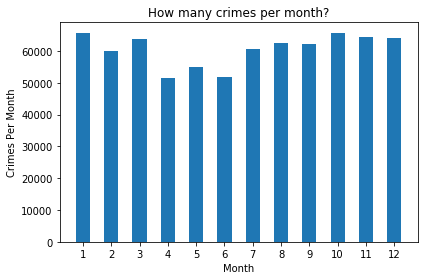

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
y_axis = [row['count'] for row in crimes_permonth]

# plot
bar_width = 0.5
objects= ([row['Month'] for row in crimes_permonth])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')
plt.xticks(y_pos, objects)
plt.xlabel('Month')
plt.ylabel('Crimes Per Month')
plt.title('How many crimes per month?')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes per month. Overall, in January [Denotes 1] crimes did occur than any other months. From January to March(1 to 3) crimes did fluctuate. But in April(4) crimes dropped and it was above 50000. From April to June (4-6) again crimes did fluctuate but in July(7) crimes started to increase again and remained steady from July to September (7-9). Again in October it did rise a little bit and did fluctuate a little bit till December(12). 

## Top 20 suburbs where most crimes take place
### Here Four columns are selected and then they are groupped based on 'Suburb - Incident','Postcode - Incident'. I am considering Offence Count denotes crime that's why I used sum.

In [46]:
crime_suburbs = df.select('Reported Date','Offence Count','Suburb - Incident','Postcode - Incident').groupBy('Suburb - Incident','Postcode - Incident').sum().withColumnRenamed('sum(Offence Count)','sum').orderBy('sum',ascending=False).take(20)
displayCrimes= (["{}-{} -> {}".format(row['Suburb - Incident'],row['Postcode - Incident'],row['sum']) for row in crime_suburbs])
print(*displayCrimes,sep = "\n")

ADELAIDE-5000 -> 46701
PORT AUGUSTA-5700 -> 13711
MOUNT GAMBIER-5290 -> 13709
MURRAY BRIDGE-5253 -> 12919
MORPHETT VALE-5162 -> 12569
SALISBURY-5108 -> 10806
PORT LINCOLN-5606 -> 10779
ELIZABETH-5112 -> 10731
NOT DISCLOSED-NOT DISCLOSED -> 9375
DAVOREN PARK-5113 -> 8082
PARAFIELD GARDENS-5107 -> 8040
OAKLANDS PARK-5046 -> 7792
PARALOWIE-5108 -> 7261
PROSPECT-5082 -> 7234
PORT PIRIE-5540 -> 7155
MODBURY-5092 -> 7041
SMITHFIELD-5114 -> 7000
SALISBURY NORTH-5108 -> 6538
WHYALLA STUART-5608 -> 6297
MAWSON LAKES-5095 -> 6103


In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

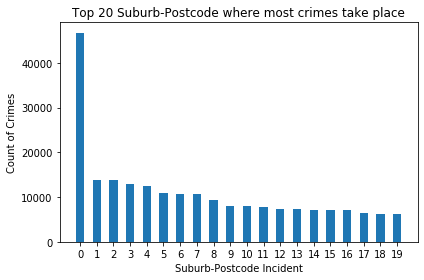

In [52]:
# prepare data
y_axis = [row['sum'] for row in crime_suburbs]

# plot
bar_width = 0.5
objects= ([row for row in range(len(crime_suburbs))])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')

plt.xticks(y_pos)
plt.xlabel('Suburb-Postcode Incident')
plt.ylabel('Count of Crimes')
plt.title('Top 20 Suburb-Postcode where most crimes take place')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes in the top twenty suburbs. Suburb with postcode ADELAIDE-5000 is denoted 0 in the bar graph. Overall, in the suburb ADELAIDE-5000 which is 0 in the x axis, in where crimes did occur than any other suburbs. In the remaining suburbs crimes did happen very less comared to first suburbs. From PORT AUGUSTA-5700 (1) to the rest of the suburbs, crimes declined slowly. From suburb SALISBURY NORTH-5108 (17) to MAWSON LAKES-5095 (19) crimes remained steady and didn't change much.

### In the following section if I consider per row as one crime - count() method is used

In [55]:
crime_suburbs = df.select('Reported Date','Offence Count','Suburb - Incident','Postcode - Incident').groupBy('Suburb - Incident','Postcode - Incident').count().orderBy('count',ascending=False).take(20)
displayCrimes= (["{}-{} -> {}".format(row['Suburb - Incident'],row['Postcode - Incident'],row['count']) for row in crime_suburbs])
print(*displayCrimes,sep = "\n")

ADELAIDE-5000 -> 21684
MOUNT GAMBIER-5290 -> 10000
PORT AUGUSTA-5700 -> 9619
MORPHETT VALE-5162 -> 9548
MURRAY BRIDGE-5253 -> 9423
NOT DISCLOSED-NOT DISCLOSED -> 8939
SALISBURY-5108 -> 8332
PORT LINCOLN-5606 -> 7848
ELIZABETH-5112 -> 7686
PARAFIELD GARDENS-5107 -> 6640
DAVOREN PARK-5113 -> 6519
PARALOWIE-5108 -> 6084
PROSPECT-5082 -> 5927
PORT PIRIE-5540 -> 5772
OAKLANDS PARK-5046 -> 5668
MODBURY-5092 -> 5537
SALISBURY NORTH-5108 -> 5492
SMITHFIELD-5114 -> 5412
WHYALLA STUART-5608 -> 5106
MAWSON LAKES-5095 -> 4863


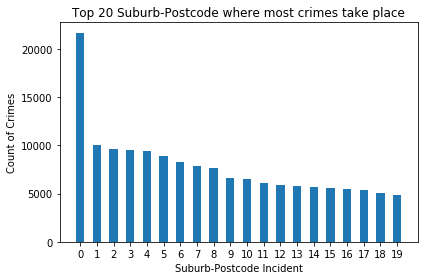

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
y_axis = [row['count'] for row in crime_suburbs]

# plot
bar_width = 0.5
objects= ([row for row in range(len(crime_suburbs))])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')

plt.xticks(y_pos)
plt.xlabel('Suburb-Postcode Incident')
plt.ylabel('Count of Crimes')
plt.title('Top 20 Suburb-Postcode where most crimes take place')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the amount of crimes in the top twenty suburbs. Suburb with postcode ADELAIDE-5000 is denoted 0 in the bar graph. Overall, in the suburb ADELAIDE-5000 which is 0 in the x axis, in where crimes did occur than any other suburbs. In the remaining suburbs crimes did happen very less comared to first suburbs. From MOUNT GAMBIER-5290 (1) to the rest of the suburbs, crimes declined slowly. From suburb SMITHFIELD-5114 (17) to MAWSON LAKES-5095 (19) crimes remained steady and didn't change much.

## Find the number of serious criminal trespasses by day and month.

In [57]:
from pyspark.sql.functions import month
trespasses_monthdf = df.filter(df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS' ).groupBy(month('Reported Date').alias('Month')).count().orderBy('Month').collect()

#### dayofmonth(col) - It extracts the day of the month of a given date as intege
#### Here we are filtering the data in the column 'Offence Level 2 Description' getting only the data 'SERIOUS CRIMINAL TRESPASS' and then grouping based on day of the month of a given date.

In [58]:
from pyspark.sql.functions import dayofmonth
trespasses_daydf = df.filter(df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS' ).groupBy(dayofmonth('Reported Date').alias('Day')).count().orderBy('Day').collect()

### In the question they told to plot a graph. From lecture slide 34 of data visualization from the second point          - If the points are color coded one additional variable can be displayed. 
### In the assessment discussion paras told to see the lecture slide and it is possible to draw the graph within one plot. That's why I have used scatter plot.

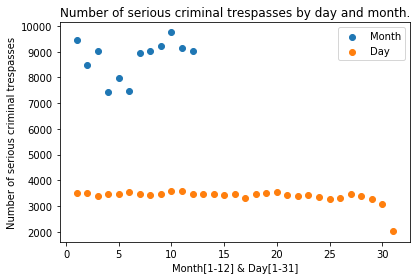

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
fare_1 = [row['Month'] for row in trespasses_monthdf]
age_1 = [row['count'] for row in trespasses_monthdf]
fare_0 = [row['Day'] for row in trespasses_daydf]
age_0 = [row['count'] for row in trespasses_daydf]

# plot
plt.scatter(fare_1, age_1, c='C0', label='Month')
plt.scatter(fare_0, age_0, c='C1', label='Day')
plt.xlabel('Month[1-12] & Day[1-31]')
plt.ylabel('Number of serious criminal trespasses')
plt.legend(loc='upper right')
plt.title('Number of serious criminal trespasses by day and month.')
plt.tight_layout()
plt.show()

### The above scatter plot illustrates the amount of number of serious criminal trespasses in days and months. In the X-axis 1 to 12 represents for the months and in the same axis 1 to 31 represents for the day. 
### If day is considered first then I woud say number of serious criminal trespasses remained steady and didn't change much and at the last day of a month serious criminal trespasses  was much low compared to any other day. 
### If month is considered then, when the months increase from Jan to July, no of serious criminal trespasses  did decrease and fluctuate. The relationship is not strong from the month Jan to July. No results are very far from each other. If we want to make a cluster for months, we can make three cluster for month Jan to Mar, Apr to Jun and rest of the months to another cluster. From July to december serious criminal trespasses did increase slowly and last two months remained steady. 

## Additional: We can plot two separate bar chart for months and days

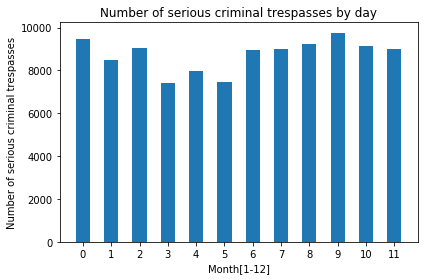

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
y_axis = [row['count'] for row in trespasses_monthdf]

# plot
bar_width = 0.5
objects= ([row for row in range(len(trespasses_monthdf))])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')

plt.xticks(y_pos)
plt.xlabel('Month')
plt.ylabel('Number of serious criminal trespasses')
plt.title('Number of serious criminal trespasses by months')
plt.tight_layout()
plt.show()

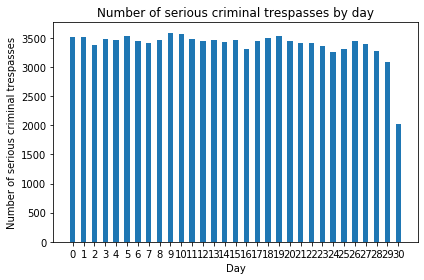

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

# prepare data
y_axis = [row['count'] for row in trespasses_daydf]

# plot
bar_width = 0.5
objects= ([row for row in range(len(trespasses_daydf))])
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')

plt.xticks(y_pos)
plt.xlabel('Day')
plt.ylabel('Number of serious criminal trespasses')
plt.title('Number of serious criminal trespasses by day')
plt.tight_layout()
plt.show()